# Project 3: Web APIs & NLP

---

## Part 3: Data Preprocessing & Modelling

### Contents:

- [Data Preprocessing](#Data-Preprocessing)
- [Modelling](#Modelling)
- [Summary](#Summary)
- [Recommendations and Future Works](#Recommendations-and-Future-Works)

---

#### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from bs4 import BeautifulSoup

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay,
accuracy_score, f1_score, plot_roc_curve, roc_auc_score, RocCurveDisplay)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, ExtraTreesClassifier

#### Read in datasets

In [2]:
ps4 = pd.read_csv("../datasets/ps4_clean.csv")
ps5 = pd.read_csv("../datasets/ps5_clean.csv")

In [3]:
ps4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2883 entries, 0 to 2882
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  2883 non-null   object
 1   id         2883 non-null   object
 2   title      2883 non-null   object
 3   selftext   2883 non-null   object
dtypes: object(4)
memory usage: 90.2+ KB


In [4]:
ps5.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6900 entries, 0 to 6899
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  6900 non-null   object
 1   id         6900 non-null   object
 2   title      6900 non-null   object
 3   selftext   6900 non-null   object
dtypes: object(4)
memory usage: 215.8+ KB


## Data Preprocessing

In [5]:
# Merge both dataframes
df = pd.concat([ps4, ps5], axis=0) 

In [6]:
df.shape

(9783, 4)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9783 entries, 0 to 6899
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  9783 non-null   object
 1   id         9783 non-null   object
 2   title      9783 non-null   object
 3   selftext   9783 non-null   object
dtypes: object(4)
memory usage: 382.1+ KB


#### Binarize target variable

Convert PS4 and PS5 in `subreddit` into binary labels:
 - 0 for PS4
 - 1 for PS5

In [8]:
df['subreddit'] = df['subreddit'].map({'PS4': 0, 'PS5': 1})

In [9]:
df['subreddit'].value_counts()

1    6900
0    2883
Name: subreddit, dtype: int64

After data cleaning, we find that there are more valid posts retrieved from PS5 subreddit than PS4.

As the PS5 is the latest gaming console from Sony, we can expect more active discussions in terms of new game releases, announcements and reviews made, as compared to the PS4, resulting in higher number of valid posts.

With an imbalanced dataset, we can use other metrics such as the F1 score to assess the classifier.

#### Engineer new feature `post`

During data cleaning, many `selftext` rows are found blank. However, we can still utilise the words from `title`. We will engineer a new feature called `post` by combining `title` and `selftext`, in order to build on the list of features for modelling.

In [10]:
# Create new `post` consisting of `title` and `selftext`
df['post'] = df['title'] + ' ' + df['selftext']

In [11]:
df.head(2)

,subreddit,id,title,selftext,post
0,0,vobgp9,How long do you play a game before you decide ...,I know that some games take some time to reall...,How long do you play a game before you decide ...
1,0,vob0uc,God of War Ragnarok Release Date Announcement ...,,God of War Ragnarok Release Date Announcement ...


In [12]:
# Drop unwanted features
df.drop(['id', 'title', 'selftext'], axis=1, inplace=True)

In [13]:
df.head()

,subreddit,post
0,0,How long do you play a game before you decide ...
1,0,God of War Ragnarok Release Date Announcement ...
2,0,One Piece Odyssey - Gameplay
3,0,One Piece Odyssey - Dev Diary
4,0,Upgrade Ps4 to Ps5 I have the original Ps4 and...


In [14]:
df.to_csv("../datasets/combined.csv", index=False)

#### Train/test split dataset

In [15]:
# Perform train/test split for data preprocessing:
X = df['post']
y = df['subreddit']

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9783 entries, 0 to 6899
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subreddit  9783 non-null   int64 
 1   post       9783 non-null   object
dtypes: int64(1), object(1)
memory usage: 229.3+ KB


In [17]:
y.value_counts(normalize=True)

1    0.705305
0    0.294695
Name: subreddit, dtype: float64

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.20,
                                                    stratify=y,
                                                    random_state=42
                                                   )

In [19]:
X_train.shape

(7826,)

In [20]:
X_test.shape

(1957,)

#### Tokenize and lemmatize

In [21]:
# Update list of stopwords
stop_words = set(stopwords.words('english'))
add_stopwords = ['ps4', 'ps5', 'playstation', 'game', 'video', 'sony' 'ps', 'plus', 'got', 'just']

stop_words = stop_words.union(add_stopwords)

In [22]:
# Instantiate lemmatizer.
lemmatizer = WordNetLemmatizer()

In [23]:
# Create function to further clean `post`

def clean_post(raw_post):
    
    # 1. Remove HTML.
    html_removed = BeautifulSoup(raw_post).get_text()
    
    # 2. Remove http.
    http_removed = re.sub(r"http\S+", "", html_removed)
    
    # 3. Remove www.
    www_removed = re.sub(r"www\S+", "", http_removed)
    
    # 4. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ",  www_removed)
    
    # 5. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    #6. Lemmatize word tokens.
    tokens_lem = [lemmatizer.lemmatize(i) for i in words]
   
    # 7. Remove stopwords.
    meaningful_words = [w for w in tokens_lem if not w in stop_words]
    
    # 8. Join the words back into one string separated by space and return the result.
    return(" ".join(meaningful_words))

In [24]:
# Get the number of posts based on the dataframe size.
total_posts = df.shape[0]
print(f'There are {total_posts} posts.')

There are 9783 posts.


In [25]:
# Initialize an empty list to hold clean posts.
clean_train_post = []
clean_test_post = []

In [26]:
# Clean 'post' 

print("Cleaning and parsing the training set posts...")

# Instantiate counter.
j = 0

# For every post in our training set...
for train_post in X_train:
    
    # Convert post to words, then append to clean_train_post.
    clean_train_post.append(clean_post(train_post))
    
    # If the index is divisible by 1000, print a message.
    if (j + 1) % 1000 == 0:
        print(f'{j + 1} of {total_posts} posts.')
    
    j += 1

# Let's do the same for our testing set.
print("Cleaning and parsing the testing set posts...")

# For every post in our testing set...
for test_post in X_test:
    
    # Convert post to words, then append to clean_test_post.
    clean_test_post.append(clean_post(test_post))
    
    # If the index is divisible by 1000, print a message.
    if (j + 1) % 1000 == 0:
        print(f'{j + 1} of {total_posts} posts.')
        
    j += 1
print('Cleaning for all posts completed')

Cleaning and parsing the training set posts...


C:\Users\chang\anaconda3\envs\dsi30\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


1000 of 9783 posts.
2000 of 9783 posts.
3000 of 9783 posts.
4000 of 9783 posts.
5000 of 9783 posts.
6000 of 9783 posts.
7000 of 9783 posts.
Cleaning and parsing the testing set posts...
8000 of 9783 posts.
9000 of 9783 posts.
Cleaning for all posts completed


In [27]:
# Store cleaned posts back in train/test sets
X_train = clean_train_post
X_test = clean_test_post

## Modelling

We will create our models using a mixture of transformers and classifiers:
1. CountVectorizer and Multinomial Naive Bayes
2. TF-IDF Vectorizer and Multinomial Naive Bayes
3. CountVectorizer and Logistic Regression
4. TF-IDF Vectorizer and Logistic Regression
5. CountVectorizer and Decision Tree Classifier
6. TF-IDF Vectorizer and Decision Tree Classifier
7. CountVectorizer and Random Forest Classifier
8. TF-IDF Vectorizer and Random Forest Classifier

#### Baseline model

We will first establish a baseline model for our prediction before running the classification models.

In [28]:
y_train.value_counts(normalize=True)

1    0.705341
0    0.294659
Name: subreddit, dtype: float64

The baseline model has a 70% accuracy of predicting the correct subreddit. We will evaluate the classification models whether they can provide a better prediction by obtaining higher accuracy scores.

#### Model 1 - CountVectorizer + MultinomialNB

In [29]:
# Set up pipeline, hyperparameters and GridSearch
pipe1 = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

pipe1_params = {
    'cvec__max_features': [4000],      #[1000, 2000, 3000, 3500, 4500, 5000]
    'cvec__min_df': [1],               #[2, 3]
    'cvec__max_df': [.90],             #[0.95, 0.85, 0.80, ]
    'cvec__ngram_range': [(1,4)]       #[(1,1), (1,2), (1,3), (1,5) ]
}

gs1 = GridSearchCV(pipe1,
                   param_grid=pipe1_params, 
                   cv=5,
                   n_jobs=-1,
                   verbose=1
                  )

In [30]:
gs1.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__memory', 'estimator__steps', 'estimator__verbose', 'estimator__cvec', 'estimator__nb', 'estimator__cvec__analyzer', 'estimator__cvec__binary', 'estimator__cvec__decode_error', 'estimator__cvec__dtype', 'estimator__cvec__encoding', 'estimator__cvec__input', 'estimator__cvec__lowercase', 'estimator__cvec__max_df', 'estimator__cvec__max_features', 'estimator__cvec__min_df', 'estimator__cvec__ngram_range', 'estimator__cvec__preprocessor', 'estimator__cvec__stop_words', 'estimator__cvec__strip_accents', 'estimator__cvec__token_pattern', 'estimator__cvec__tokenizer', 'estimator__cvec__vocabulary', 'estimator__nb__alpha', 'estimator__nb__class_prior', 'estimator__nb__fit_prior', 'estimator', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])

In [31]:
%%time
# Fit GridSearch to training data.
gs1.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: total: 1.53 s
Wall time: 8.45 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.9], 'cvec__max_features': [4000],
                         'cvec__min_df': [1], 'cvec__ngram_range': [(1, 4)]},
             verbose=1)

In [32]:
# Model 1 best parameters
gs1.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 4000,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 4)}

In [33]:
print(f"Model 1 Train score: {gs1.score(X_train, y_train)}")
print(f"Model 1 Test score: {gs1.score(X_test, y_test)}")
print(f"Model 1 CV score: {gs1.best_score_}")

Model 1 Train score: 0.7984922054689496
Model 1 Test score: 0.7353091466530404
Model 1 CV score: 0.7421407790957202


In [34]:
gs1_features = gs1.best_estimator_[0].get_feature_names_out()
gs1_features

array(['aaa', 'ability', 'able', ..., 'zero dawn', 'zombie', 'zone'],
      dtype=object)

In [35]:
log_prob_diff = gs1.best_estimator_.steps[1][1].feature_log_prob_[1] - gs1.best_estimator_.steps[1][1].feature_log_prob_[0]
log_prob_diff

array([ 0.42490538,  0.07659868,  0.26940152, ..., -0.90423057,
       -0.13104068,  0.07659868])

In [36]:
gs1_df = pd.DataFrame(log_prob_diff, index=gs1_features, columns=['log_prob'])

In [37]:
gs1_df.sort_values(by='log_prob', ascending=False).head(30)

,log_prob
dualsense,3.877690
vrr,3.443895
dual sense,3.072331
preview,2.909812
capture,2.909812
performance mode,2.849187
fidelity,2.784649
plate,2.784649
queue,2.715656
accessory,2.715656


In [38]:
# Get predictions
preds = gs1.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
cm = confusion_matrix(y_test, preds)

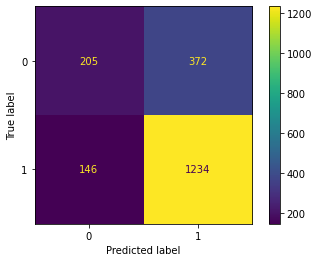

In [39]:
# View confusion matrix
disp = ConfusionMatrixDisplay(cm)
disp.plot();

In [40]:
# Calculate F1 score
print(f"Model 1 F1 score: {f1_score(y_test, preds)}")

Model 1 F1 score: 0.826523777628935


#### Model 2 - TF-IDF Vectorizer + MultinomialNB

In [41]:
# Set up pipeline, hyperparameters and GridSearch
pipe2 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

pipe2_params = {
    'tvec__max_features': [4500],     #[1000, 3000, 3500, 4000, 5000]
    'tvec__min_df': [2],              #[1,3]
    'tvec__max_df': [.85],            #[0.95, 0.9, 0.8]
    'tvec__ngram_range': [(1,2)]      #[(1,4), (1,3)]
}

gs2 = GridSearchCV(pipe2,
                   param_grid=pipe2_params, 
                   cv=5,
                   n_jobs=-1,
                   verbose=1
                  )

In [42]:
gs2.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__memory', 'estimator__steps', 'estimator__verbose', 'estimator__tvec', 'estimator__nb', 'estimator__tvec__analyzer', 'estimator__tvec__binary', 'estimator__tvec__decode_error', 'estimator__tvec__dtype', 'estimator__tvec__encoding', 'estimator__tvec__input', 'estimator__tvec__lowercase', 'estimator__tvec__max_df', 'estimator__tvec__max_features', 'estimator__tvec__min_df', 'estimator__tvec__ngram_range', 'estimator__tvec__norm', 'estimator__tvec__preprocessor', 'estimator__tvec__smooth_idf', 'estimator__tvec__stop_words', 'estimator__tvec__strip_accents', 'estimator__tvec__sublinear_tf', 'estimator__tvec__token_pattern', 'estimator__tvec__tokenizer', 'estimator__tvec__use_idf', 'estimator__tvec__vocabulary', 'estimator__nb__alpha', 'estimator__nb__class_prior', 'estimator__nb__fit_prior', 'estimator', 'n_jobs', 'param_grid', 'pre_dispatch', 'refit', 'return_train_score', 'scoring', 'verbose'])

In [43]:
%%time
# Fit GridSearch to training data.
gs2.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: total: 547 ms
Wall time: 2.74 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'tvec__max_df': [0.85], 'tvec__max_features': [4500],
                         'tvec__min_df': [2], 'tvec__ngram_range': [(1, 2)]},
             verbose=1)

In [44]:
# Model 2 best parameters
gs2.best_params_

{'tvec__max_df': 0.85,
 'tvec__max_features': 4500,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 2)}

In [45]:
print(f"Model 2 Train score: {gs2.score(X_train, y_train)}")
print(f"Model 2 Test score: {gs2.score(X_test, y_test)}")
print(f"Model 2 CV score: {gs2.best_score_}")

Model 2 Train score: 0.7922310247891643
Model 2 Test score: 0.740929994890138
Model 2 CV score: 0.7484008013742509


In [46]:
gs2_features = gs2.best_estimator_[0].get_feature_names_out()

In [47]:
log_prob_diff = gs2.best_estimator_.steps[1][1].feature_log_prob_[1] - gs2.best_estimator_.steps[1][1].feature_log_prob_[0]

In [48]:
gs2_df = pd.DataFrame(log_prob_diff, index=gs2_features, columns=['log_prob'])

In [49]:
gs2_df.sort_values(by='log_prob', ascending=False).head(30)

,log_prob
vrr,2.547643
dualsense,2.509875
preview,2.036528
ign,2.022062
showcase,1.910058
soul hacker,1.903139
new trailer,1.828241
development,1.744318
trailer revealing,1.683200
hacker new,1.675047


In [50]:
# Get predictions
preds = gs2.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
cm = confusion_matrix(y_test, preds)

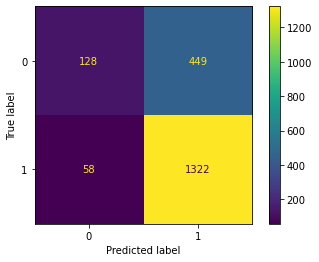

In [51]:
# View confusion matrix
disp = ConfusionMatrixDisplay(cm)
disp.plot();

In [52]:
# Calculate F1 score
print(f"Model 2 F1 score: {f1_score(y_test, preds)}")

Model 2 F1 score: 0.8390986988257696


#### Model 3 - CountVectorizer + Logistic Regression

In [53]:
# Set up pipeline, hyperparameters and GridSearch
pipe3 = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])

pipe3_params = {
    'cvec__max_features': [5000],           #[4000, 6000, 4500, 5500]
    'cvec__min_df': [2],                    #[1,3]
    'cvec__max_df': [0.85],                 #[0.9, 0.8]
    'cvec__ngram_range': [(1,2)],           #[(1,3), (1,4)]
    'lr__C': [0.1],                         #[10, 1, 0.01]
    'lr__penalty': ['l2'],                  #['l1']
    'lr__solver': ['sag'],                  #['liblinear', 'newton-cg', 'lbfgs']
    'lr__max_iter': [7000],
    'lr__class_weight': [None]              #['balanced']
}

gs3 = GridSearchCV(pipe3,
                   param_grid=pipe3_params, 
                   cv=5,
                   n_jobs=-1,
                   verbose=1
                  )

In [54]:
gs3.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__memory', 'estimator__steps', 'estimator__verbose', 'estimator__cvec', 'estimator__lr', 'estimator__cvec__analyzer', 'estimator__cvec__binary', 'estimator__cvec__decode_error', 'estimator__cvec__dtype', 'estimator__cvec__encoding', 'estimator__cvec__input', 'estimator__cvec__lowercase', 'estimator__cvec__max_df', 'estimator__cvec__max_features', 'estimator__cvec__min_df', 'estimator__cvec__ngram_range', 'estimator__cvec__preprocessor', 'estimator__cvec__stop_words', 'estimator__cvec__strip_accents', 'estimator__cvec__token_pattern', 'estimator__cvec__tokenizer', 'estimator__cvec__vocabulary', 'estimator__lr__C', 'estimator__lr__class_weight', 'estimator__lr__dual', 'estimator__lr__fit_intercept', 'estimator__lr__intercept_scaling', 'estimator__lr__l1_ratio', 'estimator__lr__max_iter', 'estimator__lr__multi_class', 'estimator__lr__n_jobs', 'estimator__lr__penalty', 'estimator__lr__random_state', 'estimator__lr__solver', 'estimator__lr__tol', 'e

In [55]:
%%time
# Fit GridSearch to training data.
gs3.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: total: 2.52 s
Wall time: 6.32 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lr', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.85], 'cvec__max_features': [5000],
                         'cvec__min_df': [2], 'cvec__ngram_range': [(1, 2)],
                         'lr__C': [0.1], 'lr__class_weight': [None],
                         'lr__max_iter': [7000], 'lr__penalty': ['l2'],
                         'lr__solver': ['sag']},
             verbose=1)

In [56]:
# Model 3 best parameters
gs3.best_params_

{'cvec__max_df': 0.85,
 'cvec__max_features': 5000,
 'cvec__min_df': 2,
 'cvec__ngram_range': (1, 2),
 'lr__C': 0.1,
 'lr__class_weight': None,
 'lr__max_iter': 7000,
 'lr__penalty': 'l2',
 'lr__solver': 'sag'}

In [57]:
print(f"Model 3 Train score: {gs3.score(X_train, y_train)}")
print(f"Model 3 Test score: {gs3.score(X_test, y_test)}")
print(f"Model 3 CV score: {gs3.best_score_}")

Model 3 Train score: 0.8345259391771019
Model 3 Test score: 0.7460398569238631
Model 3 CV score: 0.7500618984082683


In [58]:
# Get predictions
preds = gs3.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
cm = confusion_matrix(y_test, preds)

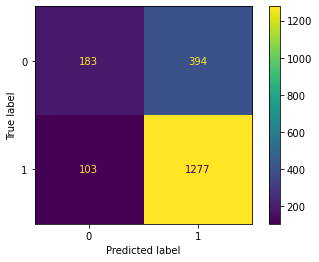

In [59]:
# View confusion matrix
disp = ConfusionMatrixDisplay(cm)
disp.plot();

In [60]:
# Calculate F1 score
print(f"Model 3 F1 score: {f1_score(y_test, preds)}")

Model 3 F1 score: 0.8371025893149787


In [61]:
gs3_features = gs3.best_estimator_[0].get_feature_names_out()
gs3_features.shape

(5000,)

In [62]:
gs3_coef = np.exp(gs3.best_estimator_.named_steps.lr.coef_).T
gs3_coef.shape

(5000, 1)

In [63]:
gs3_df = pd.DataFrame(gs3_coef, index=gs3_features, columns=['coef'])

In [64]:
gs3_df.sort_values(by='coef', ascending=False).head(30)

,coef
trailer,2.570669
dualsense,2.303214
vrr,1.882861
upgrade,1.837341
review,1.744397
event,1.711681
preview,1.663635
direct,1.638043
development,1.636384
returnal,1.610645


#### Model 4 - TF-IDF Vectorizer + Logistic Regression

In [65]:
# Set up pipeline, hyperparameters and GridSearch
pipe4 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

pipe4_params = {
    'tvec__max_features': [5000],           #[4000, 6000, 4500, 5500]
    'tvec__min_df': [1,2],                  #[1,3]
    'tvec__max_df': [0.85],                 #[0.9, 0.8]
    'tvec__ngram_range': [(1,2)],           #[(1,3), (1,4)]
    'lr__C': [1],                           #[10, 0.1, 0.01]
    'lr__penalty': ['l2'],                  #['l1']
    'lr__solver': ['sag'],                  #['sag','liblinear', 'newton-cg', 'lbfgs']
    'lr__max_iter': [7000],
    'lr__class_weight': [None]              #['balanced']
}

gs4 = GridSearchCV(pipe4,
                   param_grid=pipe4_params, 
                   cv=5,
                   n_jobs=-1,
                   verbose=1
                  )

In [66]:
gs4.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__memory', 'estimator__steps', 'estimator__verbose', 'estimator__tvec', 'estimator__lr', 'estimator__tvec__analyzer', 'estimator__tvec__binary', 'estimator__tvec__decode_error', 'estimator__tvec__dtype', 'estimator__tvec__encoding', 'estimator__tvec__input', 'estimator__tvec__lowercase', 'estimator__tvec__max_df', 'estimator__tvec__max_features', 'estimator__tvec__min_df', 'estimator__tvec__ngram_range', 'estimator__tvec__norm', 'estimator__tvec__preprocessor', 'estimator__tvec__smooth_idf', 'estimator__tvec__stop_words', 'estimator__tvec__strip_accents', 'estimator__tvec__sublinear_tf', 'estimator__tvec__token_pattern', 'estimator__tvec__tokenizer', 'estimator__tvec__use_idf', 'estimator__tvec__vocabulary', 'estimator__lr__C', 'estimator__lr__class_weight', 'estimator__lr__dual', 'estimator__lr__fit_intercept', 'estimator__lr__intercept_scaling', 'estimator__lr__l1_ratio', 'estimator__lr__max_iter', 'estimator__lr__multi_class', 'estimator__lr

In [67]:
%%time
# Fit GridSearch to training data.
gs4.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
CPU times: total: 766 ms
Wall time: 2.38 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('lr', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'lr__C': [1], 'lr__class_weight': [None],
                         'lr__max_iter': [7000], 'lr__penalty': ['l2'],
                         'lr__solver': ['sag'], 'tvec__max_df': [0.85],
                         'tvec__max_features': [5000], 'tvec__min_df': [1, 2],
                         'tvec__ngram_range': [(1, 2)]},
             verbose=1)

In [68]:
# Model 4 best parameters
gs4.best_params_

{'lr__C': 1,
 'lr__class_weight': None,
 'lr__max_iter': 7000,
 'lr__penalty': 'l2',
 'lr__solver': 'sag',
 'tvec__max_df': 0.85,
 'tvec__max_features': 5000,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 2)}

In [69]:
print(f"Model 4 Train score: {gs4.score(X_train, y_train)}")
print(f"Model 4 Test score: {gs4.score(X_test, y_test)}")
print(f"Model 4 CV score: {gs4.best_score_}")

Model 4 Train score: 0.8191924354715052
Model 4 Test score: 0.7501277465508431
Model 4 CV score: 0.7530006242884947


In [70]:
# Get predictions
preds = gs4.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
cm = confusion_matrix(y_test, preds)

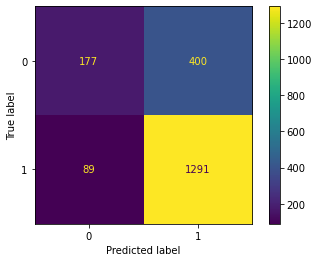

In [71]:
# View confusion matrix
disp = ConfusionMatrixDisplay(cm)
disp.plot();

In [72]:
# Calculate F1 score
print(f"Model 4 F1 score: {f1_score(y_test, preds)}")

Model 4 F1 score: 0.840768479322696


In [73]:
gs4_features = gs4.best_estimator_[0].get_feature_names_out()


In [74]:
gs4_coef = np.exp(gs4.best_estimator_.named_steps.lr.coef_).T


In [75]:
gs4_coef.shape

(5000, 1)

In [76]:
gs4_df = pd.DataFrame(gs4_coef, index=gs4_features, columns=['coef'])

In [77]:
gs4_df.sort_values(by='coef', ascending=False).head(30)

,coef
trailer,17.311560
dualsense,14.925936
vrr,11.131490
upgrade,10.697855
version,9.890452
review,6.554208
issue,6.307919
event,5.111698
ssd,4.993786
direct,4.860388


#### Model 5 - CountVectorizer + Decision Tree

In [78]:
# Set up pipeline, hyperparameters and GridSearch
pipe5 = Pipeline([
    ('cvec', TfidfVectorizer()),
    ('dt', DecisionTreeClassifier())
])

pipe5_params = {
    'cvec__max_features': [4000],            #[4500, 5000]
    'cvec__min_df': [3],                     #[1, 2]
    'cvec__max_df': [0.85],                  #[0.90, 0.80]
    'cvec__ngram_range': [(1,3)],            #[(1,2), (1,4)]
    'dt__ccp_alpha': [0],                   #[0.1, 1]                              
    'dt__max_depth': [20],                   #[10, 30]             
    'dt__min_samples_leaf': [1],             #[2, 5]
    'dt__min_samples_split': [30],           #[10, 20, 40]
    'dt__random_state': [42]                       
}

gs5 = GridSearchCV(pipe5,
                   param_grid=pipe5_params, 
                   cv=5,
                   n_jobs=-1,
                   verbose=1
                  )

In [79]:
gs5.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__memory', 'estimator__steps', 'estimator__verbose', 'estimator__cvec', 'estimator__dt', 'estimator__cvec__analyzer', 'estimator__cvec__binary', 'estimator__cvec__decode_error', 'estimator__cvec__dtype', 'estimator__cvec__encoding', 'estimator__cvec__input', 'estimator__cvec__lowercase', 'estimator__cvec__max_df', 'estimator__cvec__max_features', 'estimator__cvec__min_df', 'estimator__cvec__ngram_range', 'estimator__cvec__norm', 'estimator__cvec__preprocessor', 'estimator__cvec__smooth_idf', 'estimator__cvec__stop_words', 'estimator__cvec__strip_accents', 'estimator__cvec__sublinear_tf', 'estimator__cvec__token_pattern', 'estimator__cvec__tokenizer', 'estimator__cvec__use_idf', 'estimator__cvec__vocabulary', 'estimator__dt__ccp_alpha', 'estimator__dt__class_weight', 'estimator__dt__criterion', 'estimator__dt__max_depth', 'estimator__dt__max_features', 'estimator__dt__max_leaf_nodes', 'estimator__dt__min_impurity_decrease', 'estimator__dt__min_s

In [80]:
%%time
# Fit GridSearch to training data.
gs5.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: total: 1.41 s
Wall time: 3.89 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', TfidfVectorizer()),
                                       ('dt', DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.85], 'cvec__max_features': [4000],
                         'cvec__min_df': [3], 'cvec__ngram_range': [(1, 3)],
                         'dt__ccp_alpha': [0], 'dt__max_depth': [20],
                         'dt__min_samples_leaf': [1],
                         'dt__min_samples_split': [30],
                         'dt__random_state': [42]},
             verbose=1)

In [81]:
# Model 5 best parameters
gs5.best_params_

{'cvec__max_df': 0.85,
 'cvec__max_features': 4000,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 3),
 'dt__ccp_alpha': 0,
 'dt__max_depth': 20,
 'dt__min_samples_leaf': 1,
 'dt__min_samples_split': 30,
 'dt__random_state': 42}

In [82]:
print(f"Model 5 Train score: {gs5.score(X_train, y_train)}")
print(f"Model 5 Test score: {gs5.score(X_test, y_test)}")
print(f"Model 5 CV score: {gs5.best_score_}")

Model 5 Train score: 0.7846920521339126
Model 5 Test score: 0.7230454777721002
Model 5 CV score: 0.7245075261446309


In [83]:
# Get predictions
preds = gs5.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
cm = confusion_matrix(y_test, preds)

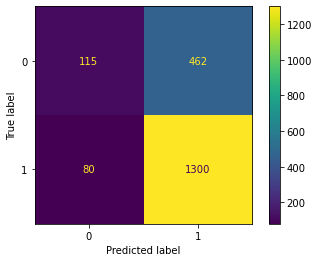

In [84]:
# View confusion matrix
disp = ConfusionMatrixDisplay(cm)
disp.plot();

In [85]:
# Calculate F1 score
print(f"Model 5 F1 score: {f1_score(y_test, preds)}")

Model 5 F1 score: 0.8274984086569064


In [86]:
gs5_features = gs5.best_estimator_[0].get_feature_names_out()

In [87]:
gs5_coef = gs5.best_estimator_.steps[1][1].feature_importances_
gs5_coef

array([0.        , 0.        , 0.00523315, ..., 0.        , 0.        ,
       0.        ])

In [88]:
gs5_df = pd.DataFrame(gs5_coef, index=gs5_features, columns=['node_prob'])

In [89]:
gs5_df.sort_values(by='node_prob', ascending=False).head(30)

,node_prob
server,0.071486
trailer,0.066256
good,0.044733
play,0.037885
slim,0.036393
friend,0.033305
episode,0.031492
played,0.025039
opinion,0.023212
asking,0.021815


#### Model 6 - TF-IDF Vectorizer + Decision Tree

In [90]:
# Set up pipeline, hyperparameters and GridSearch
pipe6 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('dt', DecisionTreeClassifier())
])

pipe6_params = {
    'tvec__max_features': [4500],            #[4000, 5000, 5500]
    'tvec__min_df': [1],                     #[2]
    'tvec__max_df': [0.85],                  #[0.80, 0.90]
    'tvec__ngram_range': [(1,2)],            #[(1,3)]
    'dt__ccp_alpha': [0] ,                   #[0.01, 0.1, 1, 10]                              
    'dt__max_depth': [20],                   #[None, 5, 10]             
    'dt__min_samples_leaf': [1],             #[2, 5, 10]
    'dt__min_samples_split': [20],           #[2,10,20,50]
    'dt__random_state': [42]                       
}

gs6 = GridSearchCV(pipe6,
                   param_grid=pipe6_params, 
                   cv=5,
                   n_jobs=-1,
                   verbose=1
                  )

In [91]:
gs6.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__memory', 'estimator__steps', 'estimator__verbose', 'estimator__tvec', 'estimator__dt', 'estimator__tvec__analyzer', 'estimator__tvec__binary', 'estimator__tvec__decode_error', 'estimator__tvec__dtype', 'estimator__tvec__encoding', 'estimator__tvec__input', 'estimator__tvec__lowercase', 'estimator__tvec__max_df', 'estimator__tvec__max_features', 'estimator__tvec__min_df', 'estimator__tvec__ngram_range', 'estimator__tvec__norm', 'estimator__tvec__preprocessor', 'estimator__tvec__smooth_idf', 'estimator__tvec__stop_words', 'estimator__tvec__strip_accents', 'estimator__tvec__sublinear_tf', 'estimator__tvec__token_pattern', 'estimator__tvec__tokenizer', 'estimator__tvec__use_idf', 'estimator__tvec__vocabulary', 'estimator__dt__ccp_alpha', 'estimator__dt__class_weight', 'estimator__dt__criterion', 'estimator__dt__max_depth', 'estimator__dt__max_features', 'estimator__dt__max_leaf_nodes', 'estimator__dt__min_impurity_decrease', 'estimator__dt__min_s

In [92]:
%%time
# Fit GridSearch to training data.
gs6.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: total: 719 ms
Wall time: 1.84 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('dt', DecisionTreeClassifier())]),
             n_jobs=-1,
             param_grid={'dt__ccp_alpha': [0], 'dt__max_depth': [20],
                         'dt__min_samples_leaf': [1],
                         'dt__min_samples_split': [20],
                         'dt__random_state': [42], 'tvec__max_df': [0.85],
                         'tvec__max_features': [4500], 'tvec__min_df': [1],
                         'tvec__ngram_range': [(1, 2)]},
             verbose=1)

In [93]:
# Model 6 best parameters
gs6.best_params_

{'dt__ccp_alpha': 0,
 'dt__max_depth': 20,
 'dt__min_samples_leaf': 1,
 'dt__min_samples_split': 20,
 'dt__random_state': 42,
 'tvec__max_df': 0.85,
 'tvec__max_features': 4500,
 'tvec__min_df': 1,
 'tvec__ngram_range': (1, 2)}

In [94]:
print(f"Model 6 Train score: {gs6.score(X_train, y_train)}")
print(f"Model 6 Test score: {gs6.score(X_test, y_test)}")
print(f"Model 6 CV score: {gs6.best_score_}")

Model 6 Train score: 0.7877587528750319
Model 6 Test score: 0.717935615738375
Model 6 CV score: 0.7216953716964735


In [95]:
# Get predictions
preds = gs6.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
cm = confusion_matrix(y_test, preds)

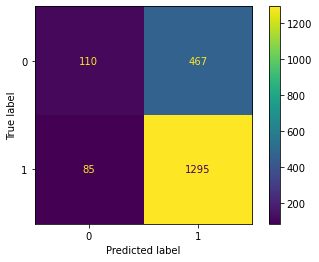

In [96]:
# View confusion matrix
disp = ConfusionMatrixDisplay(cm)
disp.plot();

In [97]:
# Calculate F1 score
print(f"Model 6 F1 score: {f1_score(y_test, preds)}")

Model 6 F1 score: 0.8243157224697645


In [98]:
gs6_features = gs6.best_estimator_[0].get_feature_names_out()
gs6_features

array(['aaa', 'ability', 'able', ..., 'zero dawn', 'zombie', 'zone'],
      dtype=object)

In [99]:
gs6_coef = gs6.best_estimator_.steps[1][1].feature_importances_
gs6_coef

array([0.        , 0.        , 0.00470747, ..., 0.        , 0.        ,
       0.        ])

In [100]:
gs6_df = pd.DataFrame(gs6_coef, index=gs6_features, columns=['node_prob'])

In [101]:
gs6_df.sort_values(by='node_prob', ascending=False).head(30)

,node_prob
server,0.068507
trailer,0.063527
good,0.045855
play,0.036589
slim,0.035068
friend,0.032456
episode,0.028104
get,0.024333
someone,0.023153
support,0.022674


#### Model 7 - CountVectorizer + Random Forest

In [102]:
# Set up pipeline, hyperparameters and GridSearch
pipe7 = Pipeline([
    ('cvec', CountVectorizer()),
    ('rt', RandomForestClassifier())
])

pipe7_params = {
    'cvec__max_features': [4500],         #[4000, 5000]      
    'cvec__min_df': [1],                  #[2]        
    'cvec__max_df': [0.85],               #[0.90]
    'cvec__ngram_range': [(1,2)],         #[(1,3)]     
    'rt__ccp_alpha': [0],                 #[1, 0.1]         
    'rt__max_depth': [None],              #[20]         
    'rt__min_samples_leaf': [1],            
    'rt__min_samples_split': [40],        #[20, 60] 
    'rt__n_estimators': [200],            #[100, 300]
    'rt__random_state': [42]                   
}

gs7 = GridSearchCV(pipe7,
                   param_grid=pipe7_params, 
                   cv=5,
                   n_jobs=-1,
                   verbose=1
                  )

In [103]:
gs7.get_params().keys()

dict_keys(['cv', 'error_score', 'estimator__memory', 'estimator__steps', 'estimator__verbose', 'estimator__cvec', 'estimator__rt', 'estimator__cvec__analyzer', 'estimator__cvec__binary', 'estimator__cvec__decode_error', 'estimator__cvec__dtype', 'estimator__cvec__encoding', 'estimator__cvec__input', 'estimator__cvec__lowercase', 'estimator__cvec__max_df', 'estimator__cvec__max_features', 'estimator__cvec__min_df', 'estimator__cvec__ngram_range', 'estimator__cvec__preprocessor', 'estimator__cvec__stop_words', 'estimator__cvec__strip_accents', 'estimator__cvec__token_pattern', 'estimator__cvec__tokenizer', 'estimator__cvec__vocabulary', 'estimator__rt__bootstrap', 'estimator__rt__ccp_alpha', 'estimator__rt__class_weight', 'estimator__rt__criterion', 'estimator__rt__max_depth', 'estimator__rt__max_features', 'estimator__rt__max_leaf_nodes', 'estimator__rt__max_samples', 'estimator__rt__min_impurity_decrease', 'estimator__rt__min_samples_leaf', 'estimator__rt__min_samples_split', 'estimato

In [104]:
%%time
# Fit GridSearch to training data.
gs7.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: total: 4.19 s
Wall time: 10.1 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('rt', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.85], 'cvec__max_features': [4500],
                         'cvec__min_df': [1], 'cvec__ngram_range': [(1, 2)],
                         'rt__ccp_alpha': [0], 'rt__max_depth': [None],
                         'rt__min_samples_leaf': [1],
                         'rt__min_samples_split': [40],
                         'rt__n_estimators': [200], 'rt__random_state': [42]},
             verbose=1)

In [105]:
# Model 7 best parameters
gs7.best_params_

{'cvec__max_df': 0.85,
 'cvec__max_features': 4500,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 2),
 'rt__ccp_alpha': 0,
 'rt__max_depth': None,
 'rt__min_samples_leaf': 1,
 'rt__min_samples_split': 40,
 'rt__n_estimators': 200,
 'rt__random_state': 42}

In [106]:
print(f"Model 7 Train score: {gs7.score(X_train, y_train)}")
print(f"Model 7 Test score: {gs7.score(X_test, y_test)}")
print(f"Model 7 CV score: {gs7.best_score_}")

Model 7 Train score: 0.9308714541272681
Model 7 Test score: 0.7301992846193153
Model 7 CV score: 0.7386905446815109


In [107]:
# Get predictions
preds = gs7.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
cm = confusion_matrix(y_test, preds)

In [108]:
# Calculate F1 score
print(f"Model 7 F1 score: {f1_score(y_test, preds)}")

Model 7 F1 score: 0.8308776425368353


In [109]:
gs7_features = gs7.best_estimator_[0].get_feature_names_out()

In [110]:
gs7_coef = gs7.best_estimator_.steps[1][1].feature_importances_
gs7_coef

array([4.37301294e-05, 5.24183462e-05, 5.21537733e-04, ...,
       5.43149262e-04, 4.70661129e-04, 2.54452105e-04])

In [111]:
gs7_df = pd.DataFrame(gs7_coef, index=gs7_features, columns=['node_prob'])

In [112]:
gs7_df.sort_values(by='node_prob', ascending=False).head(30)

,node_prob
trailer,0.009043
play,0.005815
server,0.005746
played,0.005467
good,0.005176
slim,0.004881
simulation,0.004279
episode,0.003959
friend,0.003694
looking,0.003406


#### Model 8 - TF-IDF Vectorizer + Random Forest

In [113]:
# Set up pipeline, hyperparameters and GridSearch
pipe8 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('rt', RandomForestClassifier())
])

pipe8_params = {
    'tvec__max_features': [4500],      #[4000, 5000]      
    'tvec__min_df': [2],               #[1,3 ]        
    'tvec__max_df': [0.85],                  
    'tvec__ngram_range': [(1,3)],      #[(1,2), (1,4)]     
    'rt__ccp_alpha': [0],                              
    'rt__max_depth': [None],           #[20]         
    'rt__min_samples_leaf': [1],            
    'rt__min_samples_split': [40],    #[20, 60] 
    'rt__n_estimators': [200],         # [100, 300]
    'rt__random_state': [42]                     
}

gs8 = GridSearchCV(pipe8,
                   param_grid=pipe8_params, 
                   cv=5,
                   n_jobs=-1,
                   verbose=1
                  )

In [114]:
%%time
# Fit GridSearch to training data.
gs8.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
CPU times: total: 6.47 s
Wall time: 15.6 s


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('rt', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'rt__ccp_alpha': [0], 'rt__max_depth': [None],
                         'rt__min_samples_leaf': [1],
                         'rt__min_samples_split': [40],
                         'rt__n_estimators': [200], 'rt__random_state': [42],
                         'tvec__max_df': [0.85], 'tvec__max_features': [4500],
                         'tvec__min_df': [2], 'tvec__ngram_range': [(1, 3)]},
             verbose=1)

In [115]:
# Model 8 best parameters
gs8.best_params_

{'rt__ccp_alpha': 0,
 'rt__max_depth': None,
 'rt__min_samples_leaf': 1,
 'rt__min_samples_split': 40,
 'rt__n_estimators': 200,
 'rt__random_state': 42,
 'tvec__max_df': 0.85,
 'tvec__max_features': 4500,
 'tvec__min_df': 2,
 'tvec__ngram_range': (1, 3)}

In [116]:
print(f"Model 8 Train score: {gs8.score(X_train, y_train)}")
print(f"Model 8 Test score: {gs8.score(X_test, y_test)}")
print(f"Model 8 CV score: {gs8.best_score_}")

Model 8 Train score: 0.9617940199335548
Model 8 Test score: 0.7368421052631579
Model 8 CV score: 0.742395390873963


In [117]:
# Get predictions
preds = gs8.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
cm = confusion_matrix(y_test, preds)

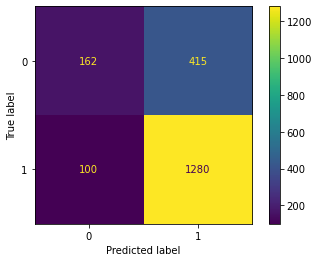

In [118]:
# View confusion matrix
disp = ConfusionMatrixDisplay(cm)
disp.plot();

In [119]:
# Calculate F1 score
print(f"Model 8 F1 score: {f1_score(y_test, preds)}")

Model 8 F1 score: 0.8325203252032519


In [120]:
gs8_features = gs8.best_estimator_[0].get_feature_names_out()

In [121]:
gs8_coef = gs8.best_estimator_.steps[1][1].feature_importances_
gs8_coef

array([1.00465873e-05, 3.98173364e-05, 4.36823713e-04, ...,
       7.17002590e-04, 3.29150120e-04, 1.22686821e-04])

In [122]:
gs8_df = pd.DataFrame(gs8_coef, index=gs8_features, columns=['node_prob'])

In [123]:
gs8_df.sort_values(by='node_prob', ascending=False).head(30)

,node_prob
trailer,0.008776
play,0.007587
looking,0.006918
played,0.006338
good,0.006093
server,0.005678
anyone,0.005305
friend,0.004810
code,0.004708
someone,0.004593


## Summary

#### Classification Models

| Classification Model                       | Train Score | Test Score | Cross Val Score | F1 Score |
|--------------------------------------------|-------------|------------|-----------------|----------|
| 1. CountVectorizer + Multinomial NB        | 0.79849     | 0.73531    | 0.74214         | 0.82652  |
| 2. TF-IDF Vectorizer + Multinomial NB      | 0.79223     | 0.74093    | 0.74840         | 0.83910  |
| 3. CountVectorizer + Logistic Regression   | 0.83453     | 0.74604    | 0.75019         | 0.83710  |
| **4. TF-IDF Vectorizer + Logistic Regression** | **0.81919**     | **0.75013**    | **0.75300**         | **0.84077**  |
| 5. CountVectorizer + Decision Tree         | 0.78469     | 0.72305    | 0.72451         | 0.82750  |
| 6. TF IDF Vectorizer + Decision Tree       | 0.78776     | 0.71794    | 0.72170         | 0.82432  |
| 7. CountVectorizer + Random Forest         | 0.93087     | 0.73020    | 0.73869         | 0.83088  |
| 8. TF IDF Vectorizer + Random Forest       | 0.96179     | 0.73684    | 0.74240         | 0.83252  |

Results from the various models are summarised in the table above. The best performing model is using a combination of TF-IDF Vectorizer and Logistic Regression, obtaining the highest cross-validation and f1 score among all the models. 

All of the models are overfitted, with higher performance score observed on the train dataset and lower score on test dataset. By applying k-fold cross validation, the models are able to learn from more dataset and thus reducing overfitting. Therefore, the cross-validation scores obtained are much to their respective test scores. 

The classification models used did not obtain a much higher score over our baseline score. This is likely due to the imbalanced dataset used. The F1 score is calculated as it gives a better measure of incorrectly classified posts than accuracy score, using the harmonic mean to penalize extreme values. In our case, false positives and false negatives are of equal importance, hence F1 score is used.


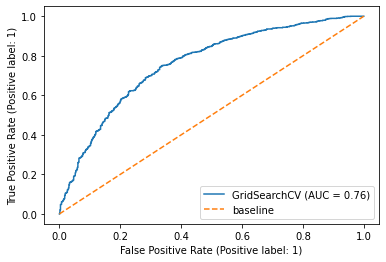

In [124]:
# ROC curve
RocCurveDisplay.from_estimator(gs4, X_test, y_test)

# add worst case scenario line
plt.plot([0,1], [0,1], label='baseline', linestyle='--')

# add a legend
plt.legend();

In [125]:
# Calculate ROC AUC.
roc_auc_score(y_test, gs4.predict_proba(X_test)[:,1])

0.7598315876723684

#### Top features

In [126]:
model_df = gs4_df.sort_values(by='coef', ascending=False).head(30)

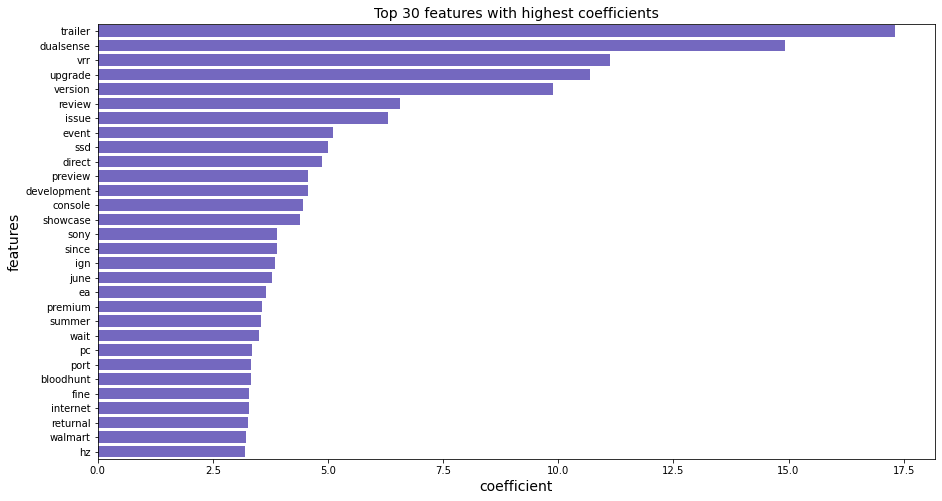

In [127]:
plt.figure(figsize = (15,8))
ax = sns.barplot(data=model_df, y=model_df.index, x='coef', color='slateblue')
plt.ylabel('features', size=14)
plt.xlabel('coefficient', size=14)
plt.title('Top 30 features with highest coefficients', size=14);

From the list of top 30 words generated, 'trailer' has obtained the highest coefficient, which is likely referring to discussions of upcoming games to be released. Other words such as 'upgrade', 'preview' and 'development' also contribute to the list of features for r/PS5, reflecting the ongoing changes and development for the console. There are technical terms such as the DualSense wireless controller and Variable Refresh Rate (VRR) specific to PS5 listed here. Lastly, game titles exclusive to the PS5 such as 'Bloodhunt' and 'Returnal' are included as well.


## Recommendations and Future Works



We have created a classification model using TF-IDF Vectorizer and Logistic Regression to differentiate between r/PS5 and r/PS4 posts. Gamers can use the classifier to determine which subreddit is more suitable to submit their post.

Our best model did not obtain a relatively higher score over our baseline model, likely due to the imbalanced dataset. To improve our model, we can consider scrapping more data from the subreddits and obtain a more balanced dataset to work with. Other classification models such as Support Vector Machines or K Nearest Neighbors can be explored and reviewed. 

For future works, we could expand the project to further classify other similar subreddits such as [r/playstation](https://www.reddit.com/r/playstation/) or [r/gaming](https://www.reddit.com/r/gaming/). Given that images and videos are commonly used in Reddit posts, we can consider decoding and adding such features to our models.